# Week 7: Unsupervised Learning

(Heavy inspired by Aurelien Geron's notebook on Unsupervised Learning: see https://github.com/ageron/handson-ml/blob/master/08_dimensionality_reduction.ipynb)

The great majority of the applications of ML today are based on supervised learning. However, the vast majority of the available data is unlabeled: we have the input features **X**, but we do not have the labels **y**. 

“If intelligence was a cake, unsupervised learning would be the cake, supervised learning would be the icing on the cake, and reinforcement learning would be the cherry on the cake.” (Yann LeCun)

There is a huge potential in unsupervised learning that haven't been explored at all yet.

## Setup

In [24]:
# Python ≥3.8 is required
import sys
assert sys.version_info >= (3, 8)

# Scikit-Learn ≥1.0 is required
import sklearn
assert sklearn.__version__ >= "1.0"

# Common imports
import numpy as np

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. K-means

### 1.1 Create some data

We generate some blobs of data that we will use to perform clustering using `sklearn.datasets.make_blobs`

In [25]:
from sklearn.datasets import make_blobs

# centres of the blobs
blob_centers = np.array(
    [[ 0.5,  2.3],
     [-1.7 ,  2.3],
     [-3.0,  1.9],
     [-3.0,  3.0],
     [-3.0,  1.4]]
)
# standard deviations of the blobs
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(
    n_samples=2000,
    centers=blob_centers,
    cluster_std=blob_std,
    random_state=7
)

Let's plot these blobs on the 2-D plane

In [26]:
def plot_clusters(X, y=None):
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        s=1
    )
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

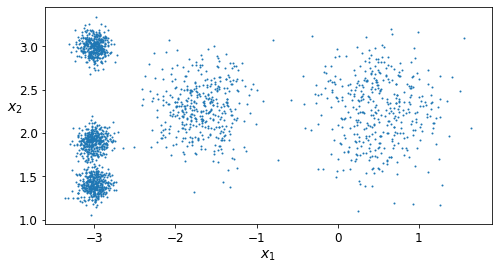

In [27]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

### 1.2 Train and predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob. Initialize a scikit-learn `KMeans` object, assigning it to a variable named `kmeans`. Pass as an argument the opportune number of clusters. Then, train train the mode and make predictions on the training data, saving the predicted clusters for each data instance in `X` in a variable `y_pred`.

In [28]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(
  n_clusters=k,
  n_init=10, # this is the default value. The algorithm will be run 10 times to improve convergence.
  random_state=42
)
y_pred = kmeans.fit_predict(X)

Now, each instance in the training data has been assigned to one of the 5 clusters:

In [29]:
# Let's print out all the predictions (i.e. predicted clusters for all the data instances in X)
y_pred

array([2, 4, 1, ..., 3, 1, 4], dtype=int32)

In [30]:
kmeans.labels_

array([2, 4, 1, ..., 3, 1, 4], dtype=int32)

In [31]:
y_pred is kmeans.labels_

True

In [32]:
kmeans.cluster_centers_

array([[-1.6748919 ,  2.28607863],
       [ 0.50051526,  2.25633653],
       [-3.00037642,  1.40082566],
       [-2.99583573,  2.99664371],
       [-3.00389616,  1.90068248]])

Now we can also predict on new data. Each new data instance is assigned to the clusted whose centroid is closer.

In [33]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 3, 3], dtype=int32)

### 1.1 Display the decision boundaries in 2D

We will use the `plot_decision_boundaries` declared in the `clustering_utils.py` module (stored in this same directory).

Have a look at the `plot_decision_boundaries` function defined above and use it to plot the decision boundaries learned by `kmeans` over the training data `X`

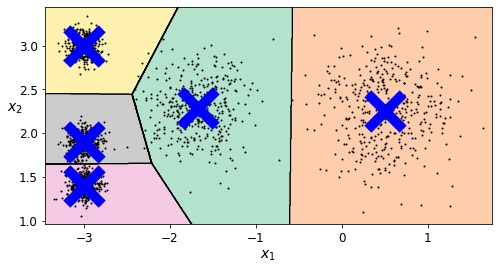

In [34]:
from clustering_utils import plot_decision_boundaries

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Notice that some of the instances near the edges have been assigned to the wrong cluster.

### 1.2 K-means algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat the following until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.
    
Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

This approach of initializing centroids, named "Kmeans++" is now the default for scikit-learn's k-means.

In [35]:
KMeans()

KMeans()

### 1.3 Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance and its centroid. This is the idea behind the _inertia_ metric:

In [36]:
kmeans.inertia_

214.36096575811834

Inertia is just the sum of the squared distances between each training instance and its closest centroid.

If we run the `transform()` method we get the distance of each instance to each of the 5 centroids:

In [37]:
X_dist = kmeans.transform(X)
X_dist  # For each instance we have the distance to each centroid (5 centroids, 5 distance measures)

array([[1.48431859, 3.49414332, 0.11146795, 1.55424074, 0.46731314],
       [1.44941221, 3.59187337, 0.51431557, 1.08973629, 0.07128222],
       [3.14049451, 1.32555654, 4.26736972, 4.63180544, 4.32673106],
       ...,
       [1.47578184, 3.56763102, 1.52865781, 0.06754735, 1.02879903],
       [2.21844572, 0.15013723, 3.6795024 , 3.58621601, 3.57961095],
       [1.18568143, 3.34458565, 0.67518173, 0.95357325, 0.22734287]])

Using the predicted labels we can get for each instance the distance to the closet centroid (i.e. the predicted cluster).

In [38]:
X_dist[np.arange(len(X_dist)), kmeans.labels_]

array([0.11146795, 0.07128222, 1.32555654, ..., 0.06754735, 0.15013723,
       0.22734287])

If we sum the squared values of all these distances we get the inertia for our clusterer.

In [39]:
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

214.36096575811922

### 1.4 Finding the optimal number of clusters

So far we have cheated a bit, as we knew that our dataset was made up of 5 clusters. What if we did not know the number of clusters in advance?

Let's try and see what happens if we train two K-means clusterers with 3 and 8 clusters and check their results.

We will train them and plot the decision boundaries for both using the `plot_clusterer_comparison` function from the `clustering_utils.py` module. We will also check their inertia.

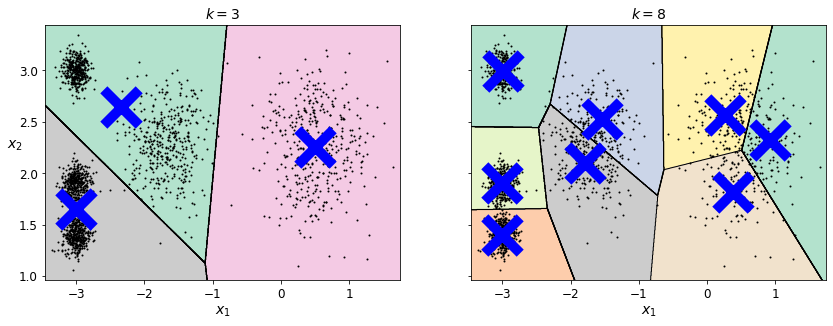

In [40]:
from clustering_utils import plot_clusterer_comparison

kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

In [41]:
kmeans_k3.inertia_, kmeans_k8.inertia_

(710.8168116555955, 120.56311113669005)

So inertia keeps getting lower as we increase $k$. The more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. 
Inertia, _per se_ is not a good performance measure to determine the optimal $k$.
However, we can plot the inertia as a function of $k$ and analyse the resulting curve:

In [42]:
kmeans_per_k = [
    KMeans(n_clusters=k, random_state=42).fit(X)
    for k in range(1, 10)
]
inertias = [model.inertia_ for model in kmeans_per_k]

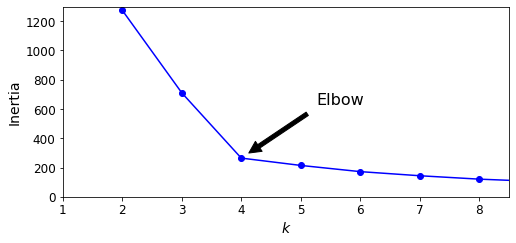

In [43]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
# add an arrow pointing to the elbow
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

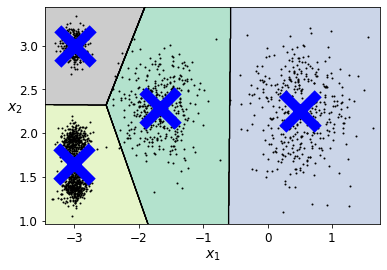

In [44]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Another approach is to look at the _silhouette score_, which is the mean _silhouette coefficient_ over all the instances. 

An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where: 
* $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_).
* $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster.

The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

A simple way to evaluate silohuette coefficients is to use the `sklearn.metrics.silhouette_score` function that returns the mean silhouette coefficient of all samples.



In [45]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.680924159958253

In the cell below we compute the silhouette score for all k values up to 10 and then plot the result:

In [46]:
silhouette_scores = [
  silhouette_score(X, model.labels_)
  for model in kmeans_per_k[1:]
]

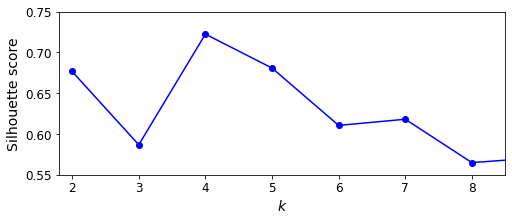

In [47]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.75])
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a _silhouette diagram_.

**Exercise:** Have a look at the `plot_silouhette_diagrams()` function in `clustering_utils.py` and use it to plot the silouhette diagrams for k values from 3 to 6.

Have a look at the graphs. What can you infer from it? We'll have a discussion in the class.

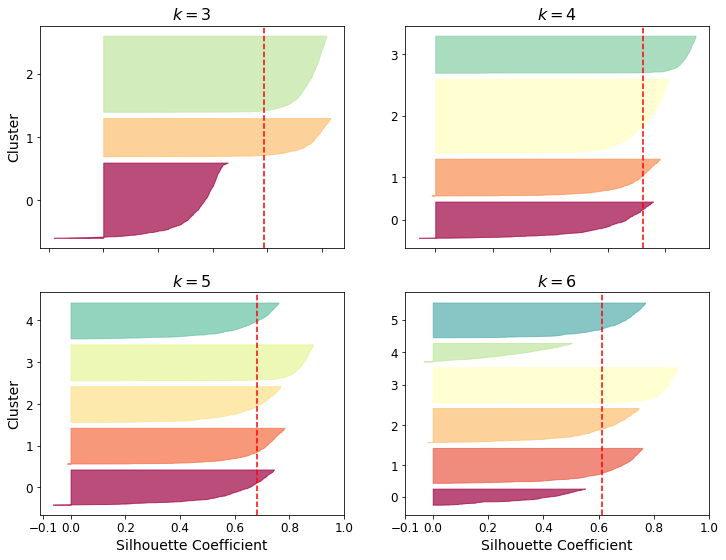

In [49]:
# Write your solution here
from clustering_utils import plot_silouhette_diagrams
plot_silouhette_diagrams(X, (3, 4, 5, 6))

**Exercise**: The Olivetti faces dataset contains 400 64x64 gray-scale images of faces of the same 40 persons, each of them flattened to a 4,096 1D vector.
  * Load the dataset (using `sklearn.datasets.fetch_olivetty_faces()`)
  * split it into training, validation, and test set (you probably want to use a stratified split to ensure the same number of pictures per person end up in each set)
  * check if the data is already scaled. If not scale it
  * cluster it using K-means, and ensure you have a good number of clusters (verify that with elbow or silouhette technique)
  * finally visualize the clusters and check if you see similar faces in each cluster 

In [ ]:
# SAMPLE: 
# TO GET YOU STARTED: 

from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load Olivetti Faces dataset
faces = fetch_olivetti_faces()
X = faces.data

# Initialize KMeans object with desired number of clusters
kmeans = KMeans(n_clusters=10)

# Fit the KMeans model to the data
kmeans.fit(X)

# Plot a sample of the original faces and their corresponding cluster centroids
fig, axes = plt.subplots(2, 5, figsize=(10, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    if i < 10:
        # Plot the i-th cluster centroid
        ax.imshow(kmeans.cluster_centers_[i].reshape(64, 64), cmap='gray')
    else:
        # Plot a sample face from the original data and assign it to its corresponding cluster centroid
        idx = kmeans.labels_[i-10] == kmeans.labels_
        ax.imshow(X[idx][0].reshape(64, 64), cmap='gray')
plt.show()


## 2. DBSCAN for clustering and anomaly detection

The DBSCAN algorithm defines clusters as continuous regions of high density. It works as follows:

* For each instance on the training set, DBSCAN counts how many instances are located within a small distance ε (epsilon) from it. This region is called the instance’s ε-neighborhood.

* If an instance has at least _m_ instances in its ε-neighborhood (including itself), then it is considered a core instance. This means that core instances are those instances located in dense regions.

* All instances in the neighborhood of a core instance belong to a cluster. This neighbourhood may include other core instances; hence, a sequence of neighbouring core instances belongs to a single cluster.

* Any instance that is not a core instance and does not have one in its neighborhood is treated as an _anomaly_. Hence, DBSCAN can be used for anomaly detection

Let's generate a dataset using the `make_moons` function:

In [26]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

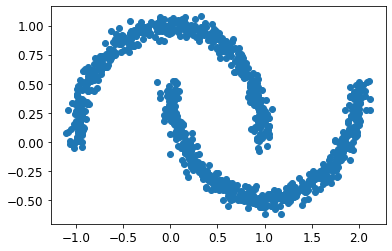

In [27]:
_ = plt.scatter(X[:, 0], X[:, 1])

Let's create and train a DBSCAN clusterer

In [28]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(
    eps=0.05,
    min_samples=5
)
dbscan.fit(X)

DBSCAN(eps=0.05)

Labels for all the instances can be found in the `labels_` attribute

In [29]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

The core instances can be found in the `core_sample_indices_` attribute.

In [30]:
len(dbscan.core_sample_indices_)

808

In this case we have 808 core instances out of 1000. The indices of the core instances can be found in the `core_sample_indices_` attribute and the core instances themselves can be found in the `components_` attribute.

In [31]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [32]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

We can check the unique values for the labels.

In [33]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

We have 7 clusters (0 to 6), while -1 is used to label any instance that did not fall into a cluster.

Let's train another DBSCAN clusterer with a different epsilon.

In [34]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

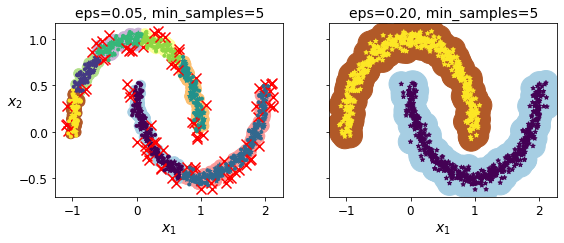

In [35]:
from clustering_utils import plot_dbscan

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

## 3. Other Clustering Algorithms (not discussed)

* Spectral Clustering
* Agglomerative Clustering


## 4. Gaussian Mixture Models

A Gaussian mixture model (GMM) is a probabilistic model that assumes that the dat instances were obtained from a weighted combination of a certain number of Gaussian distributions whose parameters (means and covariances) are unknown.

All the instances generated by from a single Gaussian Distribution will form a cluster of ellipsoidal shape with different size and orientation. You have to learn out of which distribution each data instance was generated as well as all the parameters of the distribution itself.

Parameters to be learned in this case are:
* weight of each Gaussian
* mean of each Gaussian
* covariance matrices of each Gaussian ($N \times N$ matrix, where $N$ is the number of dimensions in our input)

Let's create a `GaussianMixture` model instance and train it on the moon dataset we used for the DBSCAN.

In [36]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(
  n_components=3,
  n_init=10 # reinitialize the algorithm up to 10 times to improve convergence
)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

Like K-Means, the Expectation-Maximisation algorithm run by a GMM can end up converging to poor solutions. To overcome this, it needs to be run several times, keeping the best solution. This is why we have set n_init to 10. Warning: n_init has a default value of 1.

We can check the parameters that our model has estimated:

In [37]:
gm.weights_

array([0.20453936, 0.58686271, 0.20859793])

In [38]:
gm.means_

array([[-0.74503074,  0.55807632],
       [ 0.4950664 ,  0.25373843],
       [ 1.73110722, -0.06902321]])

In [39]:
gm.covariances_

array([[[ 0.05459987,  0.06280737],
        [ 0.06280737,  0.09028234]],

       [[ 0.16337036, -0.09692064],
        [-0.09692064,  0.28734238]],

       [[ 0.06102278,  0.06561808],
        [ 0.06561808,  0.08773031]]])

We can also check whether the algorithm has converged and how many iterations it took to converge.

In [40]:
gm.converged_, gm.n_iter_

(True, 17)

Good, the algorithm has converged. Let's now make predictions. Gaussian Mixture models can be used for both hard clustering (same as K-means and DBSCAN) but also for soft clustering (They will return a probability that a particular instance belongs to each cluster)

In [41]:
# Hard clustering
y_pred = gm.predict(X)
y_pred[:5]

array([1, 1, 1, 1, 0])

In [42]:
# Soft clustering
y_pred = gm.predict_proba(X)
y_pred[:5]

array([[9.12595056e-014, 1.00000000e+000, 2.30146837e-081],
       [7.47233037e-120, 9.99660066e-001, 3.39933511e-004],
       [2.17446845e-107, 9.99999051e-001, 9.48577999e-007],
       [1.19540587e-065, 1.00000000e+000, 1.71412532e-022],
       [9.98551631e-001, 1.44836920e-003, 1.74553662e-167]])

Now you can use `predict()` and `predict_proba()` for hard and soft clustering on new data instances. You can also use the model to generate new instances for it.

**Exercise:** try and generate 20 new samples using the `gm` model we have created and trained above.

In [ ]:
### A PLACE TO START

from sklearn.mixture import GaussianMixture
import numpy as np

# Initialize Gaussian Mixture Model object with desired number of components and covariance type
gmm = GaussianMixture(n_components=3, covariance_type='full')

# Fit the GMM model to the data
X = np.random.randn(100, 2)
gmm.fit(X)

# Generate 20 new samples from the GMM model
X_new = gmm.sample(n_samples=20)[0]

# Print the generated samples
print(X_new)


## 5. Autoencoders: a simple PCA example

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called latent representations or codings, in an unsupervised manner (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction, especially for visualization purposes. Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Finally, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data.

In the following example will build a linear autoencoder to perform PCA.

In [43]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [44]:
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

2022-07-08 10:53:31.615863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-08 10:53:31.645001: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/massi/.pyenv/versions/anaconda3-2022.05/envs/tf-data-science/lib/
2022-07-08 10:53:31.645016: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-08 10:53:31.645474: I tensorflow/core/platform/cpu_feature_guard.

This code is really not very different from all the MLPs we built in the previous classes, but there are some aspects to highlight:

* the autoencoder has two subcomponents: the encoder and the decoder. Both are regular Sequential models with a single Dense layer each, and the autoencoder is a Sequential model containing the encoder followed by the decoder

* The anumber of outputs in an autoencoder is equal to the number of inputs (i.e., 3).

* We do not use any activation function (i.e., all neurons are linear), and the cost function is the MSE. This is true for this PCA example, other models are more complicated and include non-linearities.

In [45]:
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))

/home/massi/.pyenv/versions/anaconda3-2022.05/envs/tf-data-science/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [46]:
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 0s 2ms/step - loss: 0.3019
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2836
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2667
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2520
Epoch 5/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2370
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2234
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2098
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1968
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1722
Epoch 11/20
2/2 [==============================] - 0s 1ms/step - loss: 0.1605
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1498
Epoch 13/20
2/2 [==============================] - 0s 1ms/step - loss: 0.

In [47]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


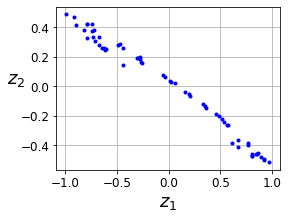

In [48]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()